# Project: Identify Customer Segments

In this project, I applied unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that I used has been provided by Udacity partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

In [29]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import Imputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. I used this information to cluster the general population into groups with similar demographic properties. Then, I have observed how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep = ';')

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

#### Observe columns 

In [70]:
# Identify missing or unknown data values and convert them to NaNs.
for index, row in feat_info.iterrows():
    feat_name = row['attribute']
    feat_nan = row['missing_or_unknown'][1:-1].split(',')
    if feat_nan != ['']:
        azdias.loc[azdias[feat_name].isin(feat_nan),feat_name] = np.nan
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1.0,2.0,3.0,4.0,3.0,5.0,5.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [71]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
# count missing values in columns

miss_cols = pd.DataFrame(azdias.isnull().sum(axis = 0), columns=['Missing_Data'])
miss_cols.head()

,Missing_Data
AGER_TYP,685843
ALTERSKATEGORIE_GROB,2881
ANREDE_KZ,0
CJT_GESAMTTYP,4854
FINANZ_MINIMALIST,0


Text(0,0.5,'counts')

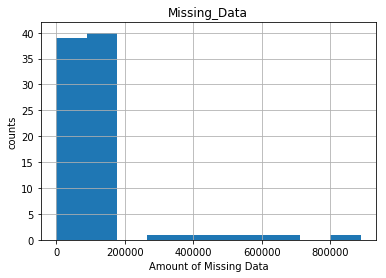

In [72]:
# Investigate patterns in the amount of missing data in each column.
miss_cols.hist()
plt.xlabel('Amount of Missing Data')
plt.ylabel('counts')


In [73]:
# remove columns with >200'000 NaNs
poor_features = miss_cols.loc[miss_cols['Missing_Data'] > 200000,:]
poor_features

,Missing_Data
AGER_TYP,685843
GEBURTSJAHR,392318
TITEL_KZ,889061
ALTER_HH,310267
KK_KUNDENTYP,584612
KBA05_BAUMAX,476524


Text(0,0.5,'counts')

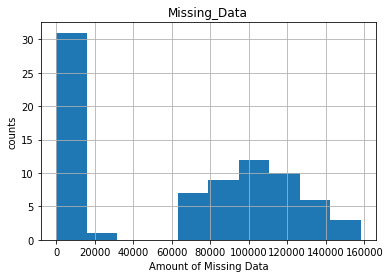

In [74]:
# plot hist one more time to see better distribution
miss_cols.loc[miss_cols['Missing_Data']< 200000].hist()
plt.xlabel('Amount of Missing Data')
plt.ylabel('counts')

In [75]:
# Features without any missing data
good_cols = miss_cols.loc[miss_cols['Missing_Data'] == 0,:]

print('Features without missing data: ', miss_cols.loc[miss_cols['Missing_Data'] == 0,:].shape[0])
print(good_cols)

Features without missing data:  24
                       Missing_Data
ANREDE_KZ                         0
FINANZ_MINIMALIST                 0
FINANZ_SPARER                     0
FINANZ_VORSORGER                  0
FINANZ_ANLEGER                    0
FINANZ_UNAUFFAELLIGER             0
FINANZ_HAUSBAUER                  0
FINANZTYP                         0
GREEN_AVANTGARDE                  0
SEMIO_SOZ                         0
SEMIO_FAM                         0
SEMIO_REL                         0
SEMIO_MAT                         0
SEMIO_VERT                        0
SEMIO_LUST                        0
SEMIO_ERL                         0
SEMIO_KULT                        0
SEMIO_RAT                         0
SEMIO_KRIT                        0
SEMIO_DOM                         0
SEMIO_KAEM                        0
SEMIO_PFLICHT                     0
SEMIO_TRADV                       0
ZABEOTYP                          0


In [76]:
# Remove the outlier columns from the dataset. 
azdias.drop(poor_features.index, axis = 1, inplace = True)

#### Discussion: Assess Missing Data in Each Column

All columns were investigated regarding the amount of missing values. My observations:
- The histogramm clearly showed that there are 6 features that clearly differ from other features in the ammount of missing data > 200'000. These features are: AGER_TYP, GEBURTSJAHR, TITEL_KZ, ALTER_HH, KK_KUNDENTYP, KBA05_BAUMAX. These features were removed from the dataset.
- Histogramm over the missing values amount of the remaining features showed two grous: low missing values fetures 0:30'000, and normally distributed group of features with values lying between 60'000 and 160'000
- There are 24 features without any missing data. Interestingly they largerly belong to 2 groups: FINANZ_xxx and SEMIO_xxx. These public sources probably were the base/core sources of the entire dataset.


#### Observe rows 

Text(0,0.5,'counts')

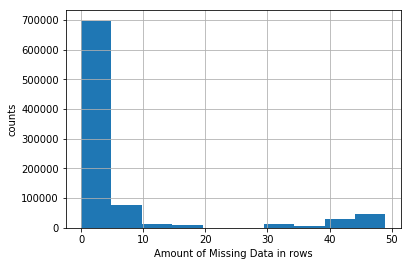

In [77]:
# How much data is missing in each row of the dataset?
miss_rows = azdias.isnull().sum(axis = 1)
miss_rows.hist()
plt.xlabel('Amount of Missing Data in rows')
plt.ylabel('counts')


In [78]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

#Define indicies of azdis related to rows with more or less 20
indicies_missing_rows = miss_rows[miss_rows > 20].index
indicies_good_rows = miss_rows[miss_rows <= 20].index

#Create DataFrames
df_miss = azdias.loc[indicies_missing_rows,:]
df = azdias.loc[indicies_good_rows,:]

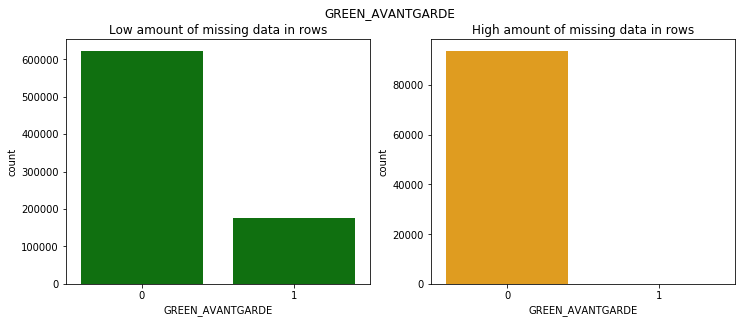

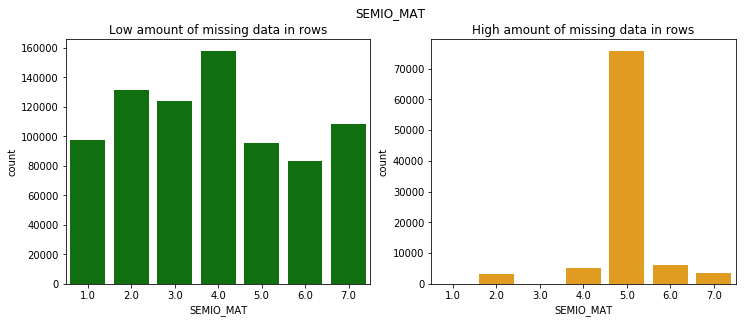

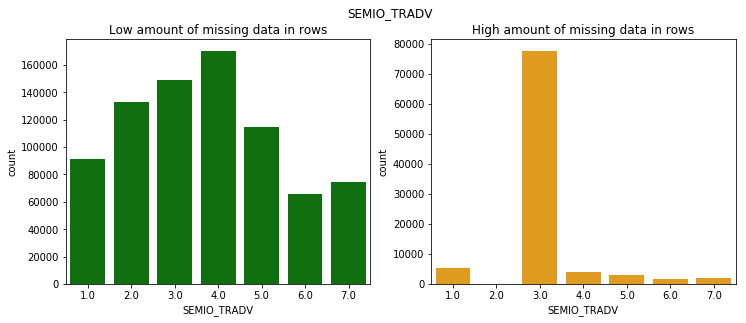

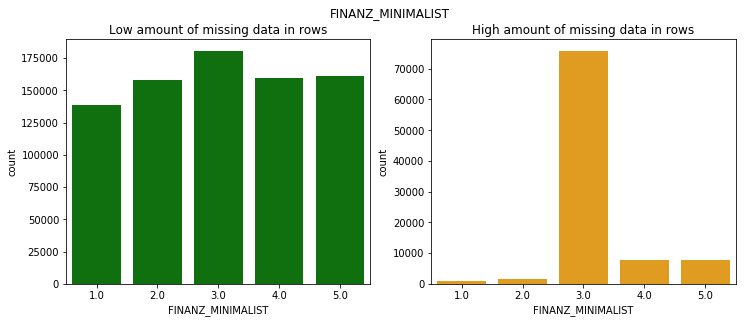

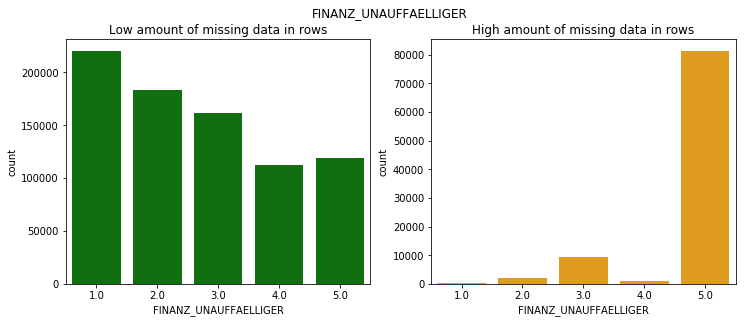

In [79]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

# Randomly define 5 columns without missing values
col_nums = np.random.randint(len(good_cols), size=(5))
cols_to_compare = good_cols.iloc[col_nums,:].index

# Create plots
for i in range(5):
    fig, axes = plt.subplots(ncols =2, figsize = (12,4.5)) 
    sns.countplot(x = cols_to_compare[i],data=df, ax = axes[0], color = 'green')
    sns.countplot(x = cols_to_compare[i],data=df_miss, ax = axes[1], color = 'orange')
    axes[0].set_title('Low amount of missing data in rows')
    axes[1].set_title('High amount of missing data in rows')
    fig.suptitle(cols_to_compare[i])

#### Discussion 1.1.3: Assess Missing Data in Each Row

All rows were investigated regarding the amount of missing values. My observations:
- The histogramm clearly showed that there are 2 groups of rows distinguished by the amount of missing values. I have set a threshold at 20. Based on that I've splitted the data into two datasets: df - all "good" rows (<=20 columns with missing data); df_miss - all "bad" rows (>20 columns with missing data)
- In order to check whether the "bad" rows are qualitevily comparable with "good" rows I have analysed their values distributions accrous the columns without any missing values. For that 5 columns were randomly chosen. The result showed that in the most cases "bad" rows group tends to have a predominant value in each column, while the values of the "good" rows group are relatively evenly distributed. Conclusion: the rows with >20 missing values are different to the rows with <=20 missing values and therefore should not be used in further work.

###  Select and Re-Encode Features

In [80]:
# How many features are there of each data type?

print(feat_info['type'].value_counts())

ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: type, dtype: int64


In [81]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

categoricals = feat_info.loc[(feat_info['type'] == 'categorical'),'attribute'].values.tolist() 

# remove already dropped column names
categoricals = list(set(categoricals) - set(poor_features.index.tolist()))

description = []

for i in categoricals:
    temp = df.loc[:,i].value_counts().index
    if type(temp[0]) != str:
        if len(temp) <= 2:
            description.append('binary')
        else:
            description.append('multi-level')
    else:
        description.append('to_encode')

res_class = pd.DataFrame({'Feature':categoricals,'Description':description})
res_class

,Description,Feature
0,to_encode,OST_WEST_KZ
1,multi-level,LP_FAMILIE_FEIN
2,multi-level,FINANZTYP
3,binary,VERS_TYP
4,multi-level,LP_STATUS_GROB
5,to_encode,CAMEO_DEUG_2015
6,multi-level,NATIONALITAET_KZ
7,multi-level,SHOPPER_TYP
8,multi-level,ZABEOTYP
9,binary,ANREDE_KZ


In [82]:
# show values of "to_encode" columns
df.loc[:,res_class.loc[res_class['Description'] == 'to_encode','Feature'].values]

,OST_WEST_KZ,CAMEO_DEUG_2015,CAMEO_DEU_2015
1,W,8,8A
2,W,4,4C
3,W,2,2A
4,W,6,6B
5,W,8,8C
6,W,4,4A
7,W,2,2D
8,W,1,1A
9,W,1,1E
10,W,9,9D


In [83]:
# Drop 'CAMEO_DEUG_2015' --> redundand information (already represended in CAMEO_DEU_2015)
res_class.drop(5, inplace = True)
df.drop('CAMEO_DEUG_2015', axis = 1, inplace = True)

In [84]:
# Re-encode categorical variable(s) to be kept in the analysis.

# Define columns that are needed to be encoded
to_encode = res_class.loc[res_class['Description'] == 'to_encode','Feature'].values

# Encode the columns
df_encode = pd.get_dummies(df.loc[:,to_encode])

# Combine with initial dataset
df = pd.concat([df,df_encode], axis = 1)

# Drop the parent columns
df.drop(to_encode, axis = 1, inplace = True)


In [87]:
df.shape

(797426, 122)

#### Discussion 1.2.1: Re-Encode Categorical Features

The task was to analyse and engineer 18 categorical features. First I have separated these features into 3 groups: binary (2 unique values), multi-level (>2 unique values) and to_encode(values of string format). All binary and multi-level variables were kept the same as they were in the dataset. The work was done on "to_encode" features. 

First of all I found out that the features "CAMEO_DEUG_2015" and "CAMEO_DEU_2015" are somewhat telling the same story (Wealth / Life Stage Typology) but with different detalisation degree. So I decided to keep the detailed one "CAMEO_DEU_2015" and removed "CAMEO_DEUG_2015".

Then I encoded two rest features "CAMEO_DEU_2015" and "OST_WEST_KZ" and appeded that to the initial dataset. In the end I removed the initial encoded columns.

#### Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). So two new variables are to be created to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Task is to break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables.

In [88]:
feat_info.loc[feat_info['type'] == 'mixed','attribute']

15      LP_LEBENSPHASE_FEIN
16      LP_LEBENSPHASE_GROB
22    PRAEGENDE_JUGENDJAHRE
56                 WOHNLAGE
59          CAMEO_INTL_2015
64             KBA05_BAUMAX
79              PLZ8_BAUMAX
Name: attribute, dtype: object

In [89]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

transf = [0,40,40,50,50,60,60,60,70,70,80,80,80,80,90,90]
#Mainstr - 0, Avantgarde = 1
movem = [-1,0,1,0,1,0,1,1,0,1,0,1,0,1,0,1]

df['PRAEGENDE_JUGENDJAHRE_DEC'] = df['PRAEGENDE_JUGENDJAHRE'].fillna(0).astype(int).apply(lambda x: transf[x])
df.loc[df['PRAEGENDE_JUGENDJAHRE_DEC'] == 0,'PRAEGENDE_JUGENDJAHRE_DEC'] = np.nan

df['PRAEGENDE_JUGENDJAHRE_MOVEM'] = df['PRAEGENDE_JUGENDJAHRE'].fillna(0).astype(int).apply(lambda x: movem[x])
df.loc[df['PRAEGENDE_JUGENDJAHRE_MOVEM'] == -1,'PRAEGENDE_JUGENDJAHRE_MOVEM'] = np.nan

df.drop('PRAEGENDE_JUGENDJAHRE',axis = 1, inplace = True)

In [90]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

df['CAMEO_INTL_2015_WEALTH'] = df['CAMEO_INTL_2015'].str[0] 
df['CAMEO_INTL_2015_LIFE_STAGE'] = df['CAMEO_INTL_2015'].str[1] 

df.drop('CAMEO_INTL_2015', axis = 1, inplace = True)

#### Discussion: Engineer Mixed-Type Features

There a 7 mixed type features in the dataset. The feature "KBA05_BAUMAX" was already removed from the analysis since it contains many missing values. 

The features "PRAEGENDE_JUGENDJAHRE" and "CAMEO_INTL_2015" contain information of multiple dimensions and therefore were engineerd so that the information was splitted into new faetures. After performing splits on both above mentioned features they were removed from dataset.

### Create a Cleaning Function
Combine all steps from above into a single "clean_function"

In [91]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    
    # convert missing value codes into NaNs, ...
    for index, row in feat_info.iterrows():
        feat_name = row['attribute']
        feat_nan = row['missing_or_unknown'][1:-1].split(',')
        if feat_nan != ['']:
            df.loc[df[feat_name].isin(feat_nan),feat_name] = np.nan
    
    # remove columns that were removed from azdias DataFrame (used list "pure_features" defined above to be consistent)
    df.drop(poor_features.index, axis = 1, inplace = True)
    
    # leave only the rows with 
    miss_rows = df.isnull().sum(axis = 1)
    indicies_good_rows = miss_rows[miss_rows <= 20].index
    df = azdias.loc[indicies_good_rows,:]
    
    # remove redundand column
    df.drop('CAMEO_DEUG_2015', axis = 1, inplace = True)
    
    # Encode the columns (used list "to_encode" defined above)
    df_encode = pd.get_dummies(df.loc[:,to_encode])
    df = pd.concat([df,df_encode], axis = 1)

    # Drop the parent columns
    df.drop(to_encode, axis = 1, inplace = True)
    
    # Transform "mixed" type features
    transf = [0,40,40,50,50,60,60,60,70,70,80,80,80,80,90,90]
    #Mainstr - 0, Avantgarde = 1
    movem = [-1,0,1,0,1,0,1,1,0,1,0,1,0,1,0,1]

    df['PRAEGENDE_JUGENDJAHRE_DEC'] = df['PRAEGENDE_JUGENDJAHRE'].fillna(0).astype(int).apply(lambda x: transf[x])
    df.loc[df['PRAEGENDE_JUGENDJAHRE_DEC'] == 0,'PRAEGENDE_JUGENDJAHRE_DEC'] = np.nan

    df['PRAEGENDE_JUGENDJAHRE_MOVEM'] = df['PRAEGENDE_JUGENDJAHRE'].fillna(0).astype(int).apply(lambda x: movem[x])
    df.loc[df['PRAEGENDE_JUGENDJAHRE_MOVEM'] == -1,'PRAEGENDE_JUGENDJAHRE_MOVEM'] = np.nan

    df.drop('PRAEGENDE_JUGENDJAHRE',axis = 1, inplace = True)
    
    df['CAMEO_INTL_2015_WEALTH'] = df['CAMEO_INTL_2015'].str[0] 
    df['CAMEO_INTL_2015_LIFE_STAGE'] = df['CAMEO_INTL_2015'].str[1] 

    df.drop('CAMEO_INTL_2015', axis = 1, inplace = True)
    
    # Return the cleaned dataframe.
    return df
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. 

In [93]:
# Check number of NaNs
print('Shape of the Dataset with NaNs: ',df.shape)
print('Shape of the Dataset without NaNs: ',df.dropna().shape)

# perform imputing using "most_frequent" strategy
imp = Imputer(strategy = 'most_frequent', axis = 0)
df_imp = imp.fit_transform(df)

Shape of the Dataset with NaNs:  (797426, 124)
Shape of the Dataset without NaNs:  (623209, 124)


In [94]:
# Apply feature scaling to the general population demographics data.
stand = StandardScaler()
df_stand = stand.fit_transform(df_imp)

### Discussion 2.1: Apply Feature Scaling

Here I had to decide what should I do with NaN values. The easiest way was to remove all rows with NaN values. If do so I would be missing more than 174'000 samples. That seems a large number to me. Therefore I decided to replace NaNs with the most frequent value along each column.

For the feature scalling the Standard Scalling method was chosen (based on the suggestion from the PCA lecture)

### Step 2.2: Perform Dimensionality Reduction

In [95]:
# Apply PCA to the data.
pca = PCA()
df_pca = pca.fit_transform(df_stand)

Text(0,0.5,'pca variance ratio (cummulativ)')

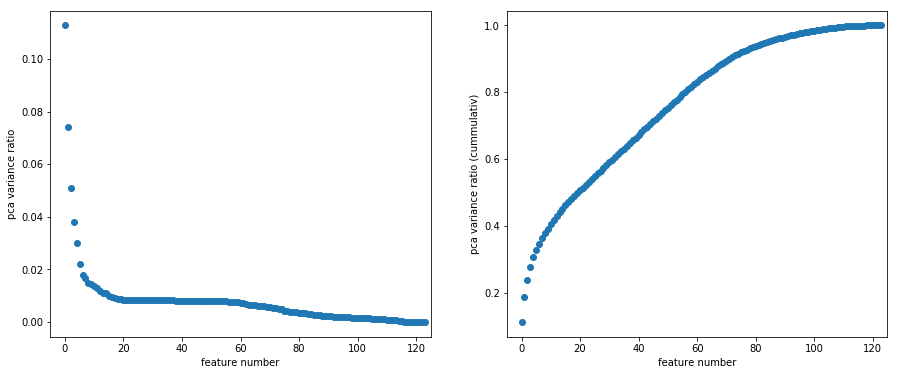

In [96]:
# Investigate the variance accounted for by each principal component.

ratio = pca.explained_variance_ratio_
k = 0
cum = []

# calculate cummulative variance
for i in ratio:
    k += i
    cum.append(k)

# create dataframe containing results    
pca_var = pd.DataFrame({'ratio':ratio,'ratio_cum':cum})

# plot results
fig, axes = plt.subplots(ncols = 2, figsize = (15,6))
pca_var['ratio'].plot(ax = axes[0], style = 'o')
pca_var['ratio_cum'].plot(ax = axes[1], style = 'o')

axes[0].set_xlim(-5,125)
axes[1].set_xlim(-5,125)


axes[0].set_xlabel('feature number')
axes[1].set_xlabel('feature number')

axes[0].set_ylabel('pca variance ratio')
axes[1].set_ylabel('pca variance ratio (cummulativ)')


In [97]:
#show a number of principal component that corresponds to cum variance >85%
pca_var.loc[pca_var['ratio_cum'] > 0.85].head(1)

,ratio,ratio_cum
63,0.006624,0.852087


In [98]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca_2 = PCA(n_components=63)
model_pca = pca_2.fit(df_stand)
df_pca_2 = model_pca.transform(df_stand)

### Discussion 2.2: Perform Dimensionality Reduction

In this part of the code I applied pca to the dataset in two steps:
1. PCA with the number of components equal to the number of features in the initial dataset. Then I've took a look into variance accounted to each principle component and calculated cummulative variance. As a result a top 63 principal components represent appr. 85% of the Dataset's variance (based on the slope of the variance curve). 
2. PCA with the number of principal components equals 63.


### Step 2.3: Interpret Principal Components

PLZ8_ANTG3                     0.195903
HH_EINKOMMEN_SCORE             0.190752
PLZ8_ANTG4                     0.189722
CAMEO_INTL_2015_WEALTH         0.187937
PLZ8_BAUMAX                    0.186521
ORTSGR_KLS9                    0.167788
EWDICHTE                       0.165471
FINANZ_HAUSBAUER               0.158992
KBA05_ANTG4                    0.136894
PLZ8_ANTG2                     0.133473
ZABEOTYP                       0.127525
KBA05_ANTG3                    0.123811
ARBEIT                         0.123569
ANZ_HAUSHALTE_AKTIV            0.122004
RELAT_AB                       0.115143
FINANZ_SPARER                  0.105671
SEMIO_PFLICHT                  0.076437
SEMIO_REL                      0.072592
PRAEGENDE_JUGENDJAHRE_DEC      0.067849
GEBAEUDETYP                    0.067219
CAMEO_DEU_2015_8A              0.064681
W_KEIT_KIND_HH                 0.063640
SEMIO_RAT                      0.063255
CAMEO_DEU_2015_9C              0.059720
CAMEO_DEU_2015_9D              0.058663


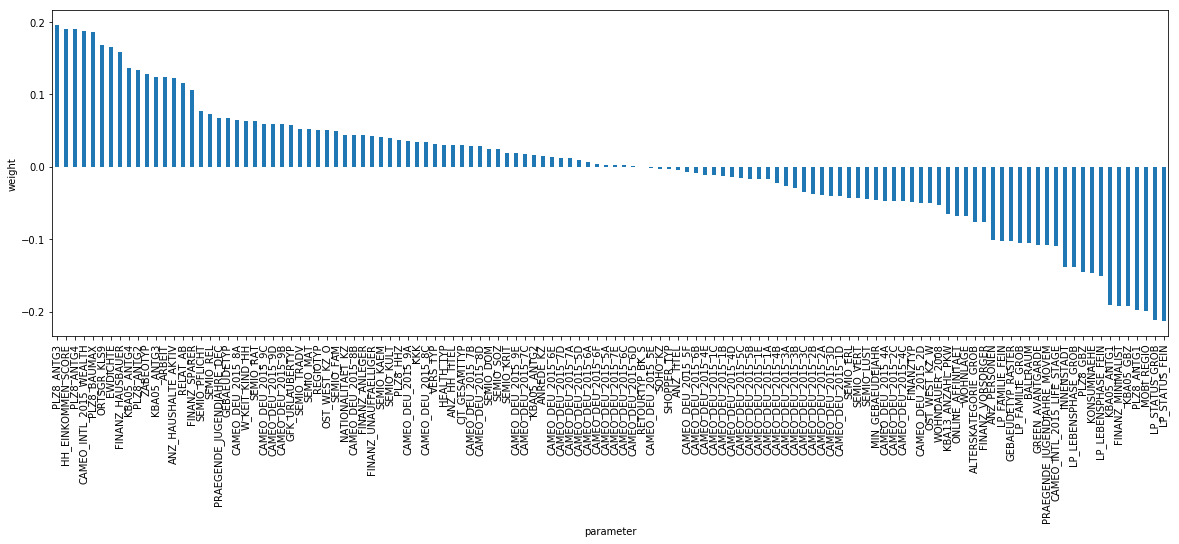

In [99]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.

def pca_feature_explore(comp_num, pca):
    '''
    Function that prints and plots the features included in the given principle component
    Input: comp_num (int) - number of principle component, pca (pca object) - actual pca object
    Output: component (pandas series) - features and coefficients included in principle component
    '''
    # create DF with all principal components and features
    pca_2_comp = pd.DataFrame(pca.components_, columns=df.columns)
    component = pca_2_comp.iloc[comp_num-1].sort_values(ascending = False)
    
    # Make a feature/weight plot
    fig, axes = plt.subplots(figsize = (20,6))
    component.plot(kind = 'bar', ax = axes)
    axes.set_ylabel('weight')
    axes.set_xlabel('parameter')

    return component

pca_feature_explore(1,model_pca)

ALTERSKATEGORIE_GROB         0.264996
FINANZ_VORSORGER             0.237464
SEMIO_ERL                    0.222208
SEMIO_LUST                   0.184166
RETOURTYP_BK_S               0.161203
W_KEIT_KIND_HH               0.119210
FINANZTYP                    0.118371
SHOPPER_TYP                  0.101921
SEMIO_KRIT                   0.101565
FINANZ_MINIMALIST            0.100201
SEMIO_KAEM                   0.088704
FINANZ_HAUSBAUER             0.086472
ANREDE_KZ                    0.071343
WOHNDAUER_2008               0.061530
EWDICHTE                     0.058252
ORTSGR_KLS9                  0.057520
PLZ8_ANTG3                   0.055993
PLZ8_ANTG4                   0.055419
SEMIO_DOM                    0.054382
PLZ8_BAUMAX                  0.051527
ARBEIT                       0.046748
KBA05_ANTG4                  0.045536
CAMEO_INTL_2015_WEALTH       0.043031
RELAT_AB                     0.041830
CAMEO_DEU_2015_9E            0.041414
ANZ_HAUSHALTE_AKTIV          0.040882
PLZ8_ANTG2  

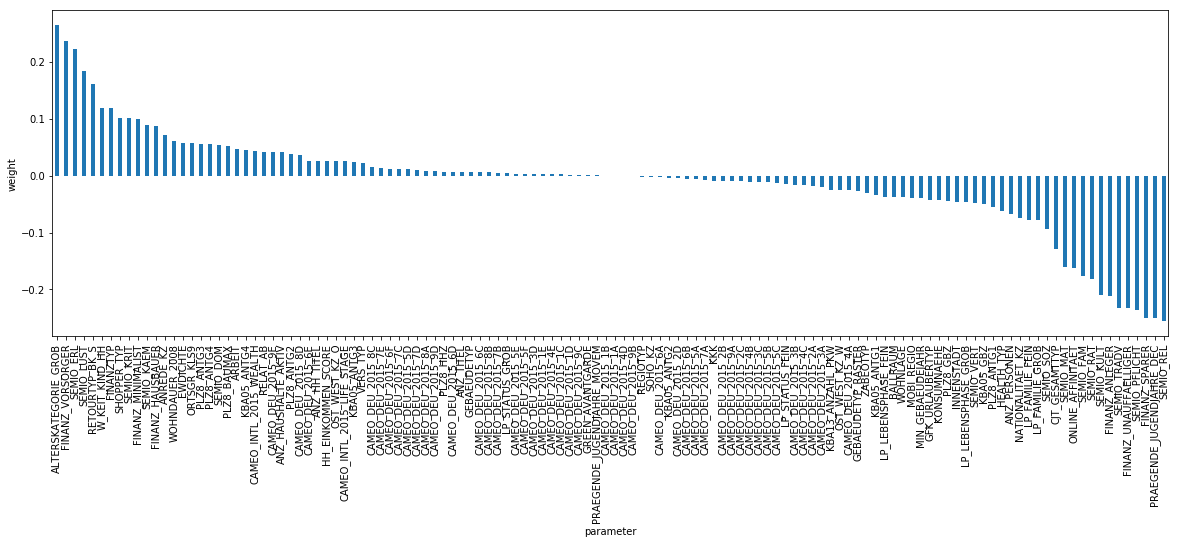

In [100]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

pca_feature_explore(2,model_pca)

SEMIO_VERT                     0.337236
SEMIO_SOZ                      0.260717
SEMIO_FAM                      0.255147
SEMIO_KULT                     0.243202
FINANZ_MINIMALIST              0.150282
FINANZTYP                      0.115464
RETOURTYP_BK_S                 0.096381
SEMIO_REL                      0.085767
FINANZ_VORSORGER               0.080517
W_KEIT_KIND_HH                 0.078222
SEMIO_MAT                      0.066754
ALTERSKATEGORIE_GROB           0.057570
PLZ8_BAUMAX                    0.052702
PRAEGENDE_JUGENDJAHRE_MOVEM    0.051318
GREEN_AVANTGARDE               0.051318
ORTSGR_KLS9                    0.049613
PLZ8_ANTG4                     0.048859
SEMIO_LUST                     0.048561
EWDICHTE                       0.047155
PLZ8_ANTG3                     0.046774
LP_STATUS_GROB                 0.040459
ARBEIT                         0.039741
RELAT_AB                       0.032024
PLZ8_ANTG2                     0.029099
WOHNDAUER_2008                 0.027209


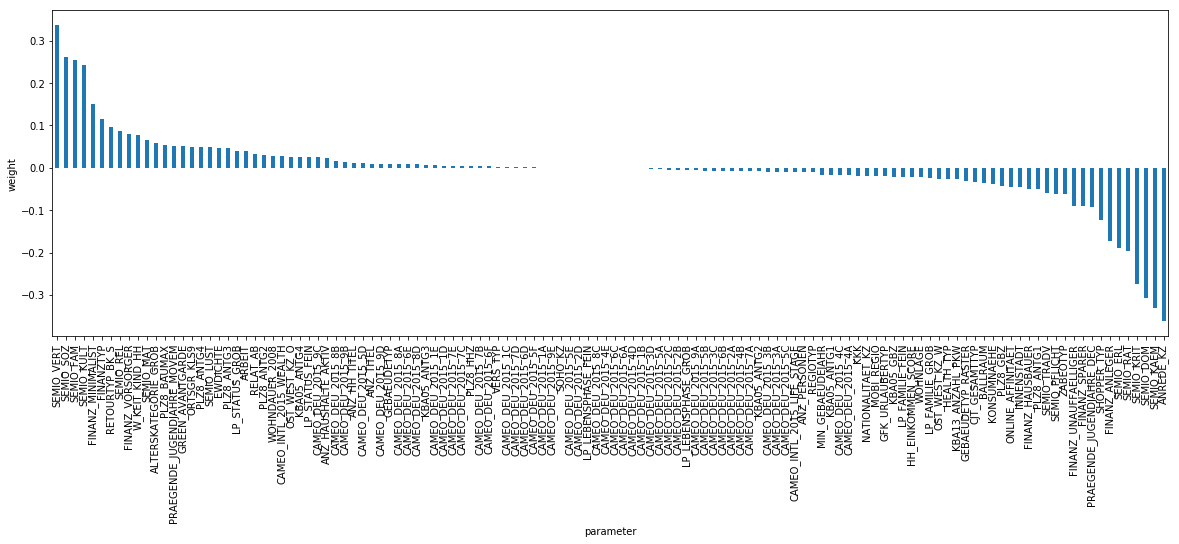

In [101]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

pca_feature_explore(3,model_pca)

### Discussion 2.3: Interpret Principal Components

Here I have investigated top three principal components:
1. In the first principal component (PC) I recognized top 2 impacts: income (HH_EINKOMMEN_SCORE, LP_STATUS_GROB/FEIN)and type of the location (PLZ8 xx). The HH_EINKOMMEN_SCORE and LP_STATUS_GROB have opposite sings since their ranking is opposite (HH_EINKOMMEN_SCORE: 1 high --> 6 very low; 1 low-earner --> 5 Top Earner). The weighst of LP_STATUS_GROB and LP_STATUS_FEIN are identical, since the features are somehow tell the same story.
2. Second PC has an age (ALTERSKATEGORIE_GROB, PRAEGENDE_JUGENDJAHRE_DEC), personality (SEMIO features) and attitude to deal with money (FINANZ_SPARER, FINANZ_VORSORGER). Interestingly that FINANZ_SPARER (tendency to save money) and FINANZ_VORSORGER (tendency to "be prepared", e.g. have some addtional ensurances e.t.c) have opposite sings, so they are opposite: money-saver will not probably buy an additional insurance.
3. The third PC is dominated by personality features (SEMIO). And has a strong impact from the gender (ANREDE_KZ).

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

In [67]:
# Over a number of different cluster counts...


    # run k-means clustering on the data and...
    
    
    # compute the average within-cluster distances.


scores = []
k_mean_amount = []

for k in range(2,30,3):  
    k_means = KMeans(k)
    model = k_means.fit(df_pca_2)
    k_mean_amount.append(k)
    scores.append(model.score(df_pca_2))
    print(k,model.score(df_pca_2))

2 -75013500.9835
5 -67708724.1396
8 -64274934.6364
11 -62090969.1405
14 -60385941.5844
17 -58646091.2393
20 -56947199.7087
23 -55512059.2114
26 -53869632.7202
29 -51575694.0838


Text(0,0.5,'PCA Score')

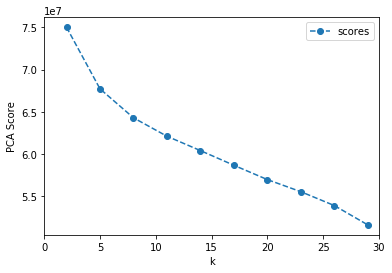

In [84]:
# Investigate the change in within-cluster distance across number of clusters.

temp = pd.DataFrame({'scores':np.abs(scores),'k':k_mean_amount})
fig, axes = plt.subplots()
temp.plot(x = 'k', y = 'scores',style = 'o--',ax = axes)
axes.set_xlim(0,30)
axes.set_ylabel('PCA Score')

In [102]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
k_means = KMeans(9)
model = k_means.fit(df_pca_2)
df_kmeans = model.transform(df_pca_2)

### Discussion 3.1: Apply Clustering to General Population

The slope of the "pca score" curve is decreased at the point k=9 and stays the same till k=30. So the amount of cluster was chosen to be 9.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters... 

In [103]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv',sep = ';')

In [104]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

#clean the data
customers_cleaned = clean_data(customers)

# impute the data (used fit_transform here --> in my opinion imputing should be based here on customer dataset)
customers_imp = imp.transform(customers_cleaned)

# normalize the data 
customers_stand = stand.transform(customers_imp)

# pca is based on general demographic data
customers_pca = model_pca.transform(customers_stand)

# kmeans
customer_kmeans = model.transform(customers_pca)

### Step 3.3: Compare Customer Data to Demographics Data

Text(0,0.5,'Ratio')

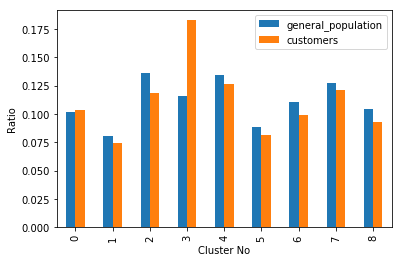

In [105]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

# create dataframe with proportions
population_clusters = pd.DataFrame(model.labels_)
pop = population_clusters[0].value_counts(normalize = True).sort_index()
cus = pd.DataFrame(customer_kmeans).idxmin(axis=1).value_counts(normalize =True).sort_index()
res = pd.concat([pop,cus],axis = 1)
res.columns = ['general_population','customers']

# plot the results
res.plot(kind = 'bar')
plt.xlabel('Cluster No')
plt.ylabel('Ratio')

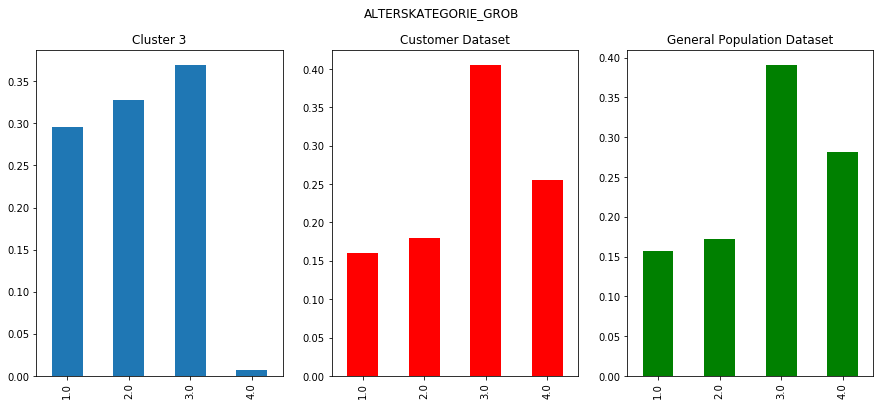

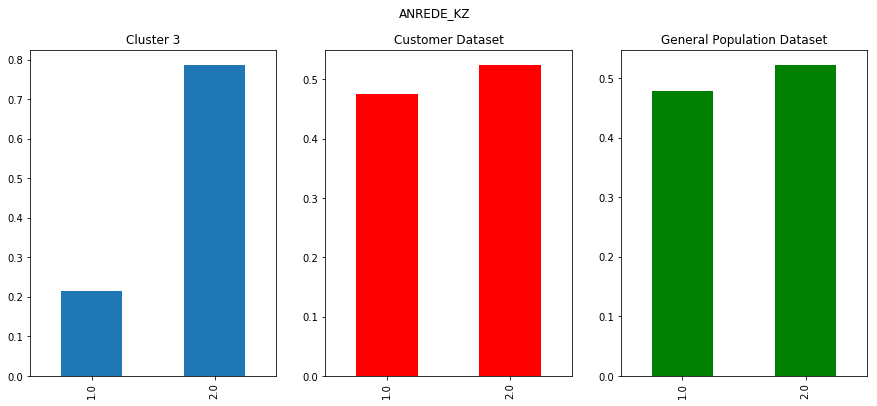

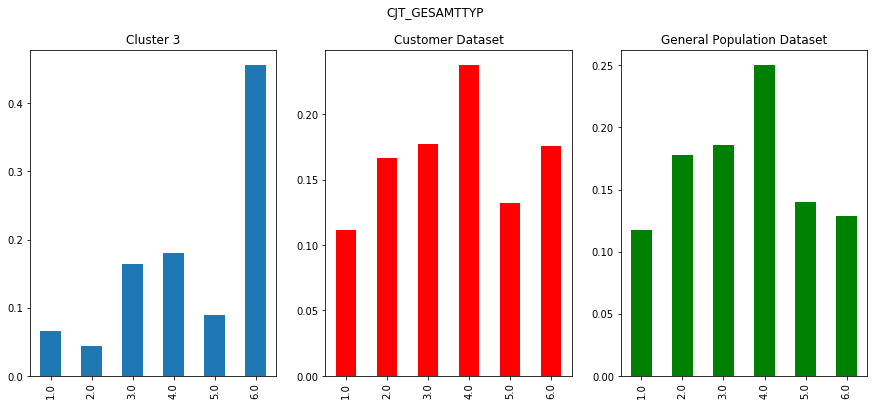

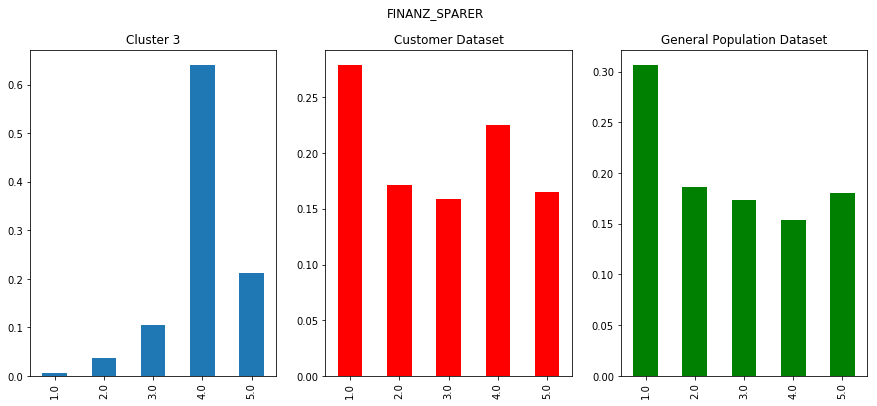

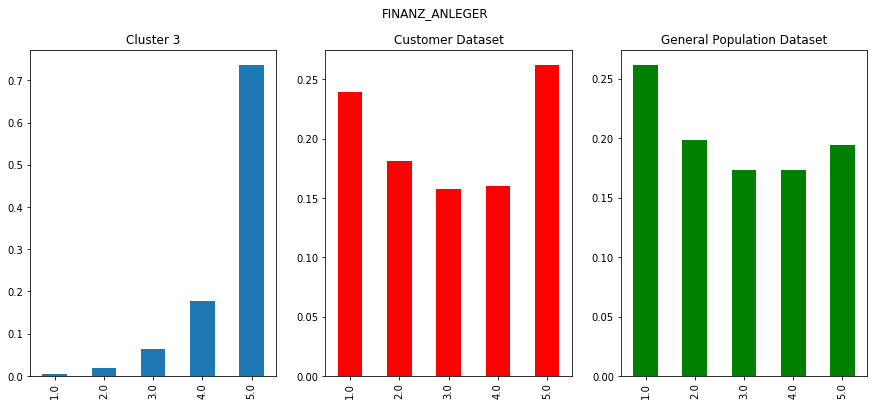

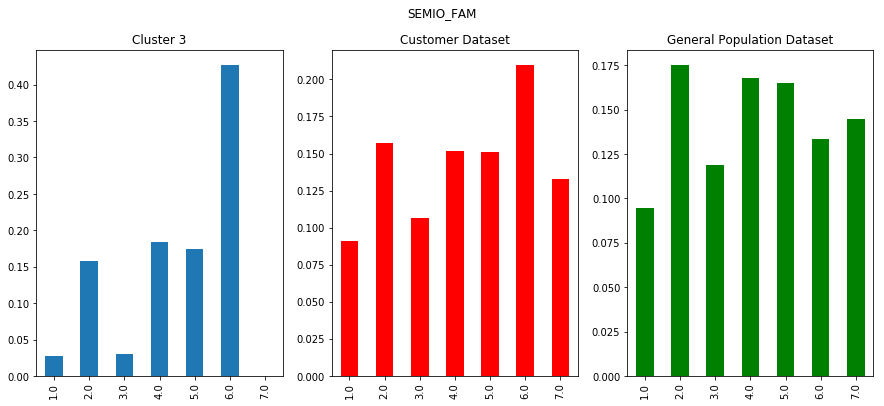

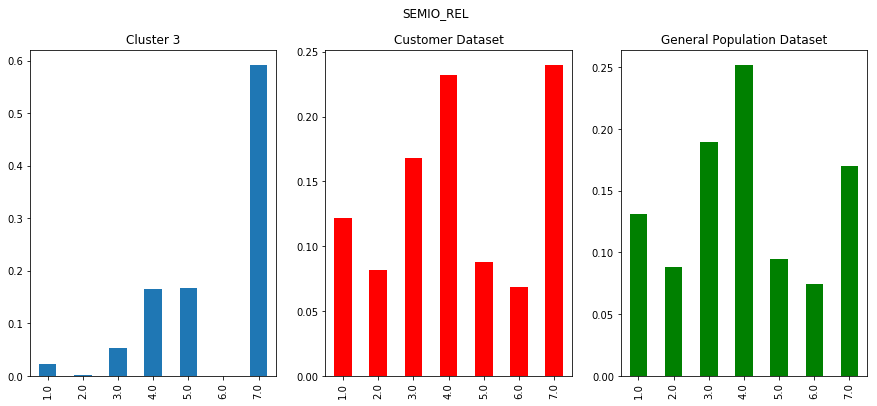

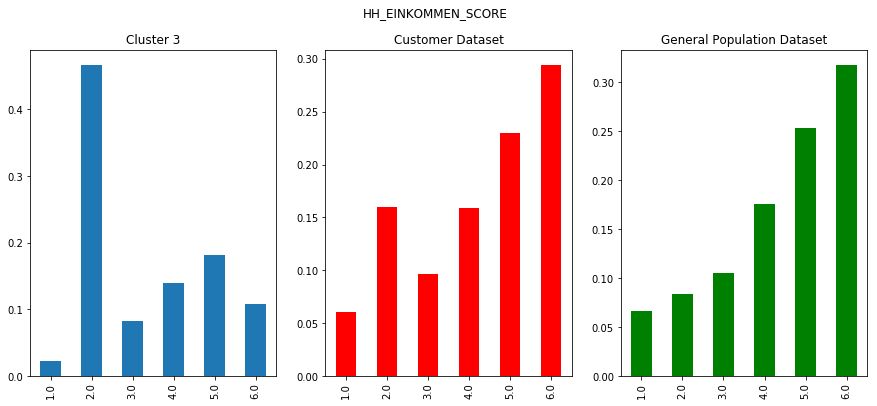

In [106]:
# Overrepresended data

# get indicies related to the cluster 3
cl_ind = pd.DataFrame(customer_kmeans).idxmin(axis=1)[pd.DataFrame(customer_kmeans).idxmin(axis=1) == 3].index
data = customers_cleaned.iloc[cl_ind,:]
list_cols = ['ALTERSKATEGORIE_GROB','ANREDE_KZ','CJT_GESAMTTYP','FINANZ_SPARER','FINANZ_ANLEGER','SEMIO_FAM','SEMIO_REL','HH_EINKOMMEN_SCORE']


# plot selected features
for i in list_cols:
    fig,axes = plt.subplots(ncols = 3, figsize = (15,6)) 
    data[i].value_counts(normalize = True).sort_index().plot(kind = 'bar', ax = axes[0])
    customers_cleaned[i].value_counts(normalize = True).sort_index().plot(kind = 'bar', ax = axes[1], color = 'red')
    df[i].value_counts(normalize = True).sort_index().plot(kind = 'bar', ax = axes[2], color = 'green')
    fig.suptitle(i)
    axes[0].set_title('Cluster 3')
    axes[1].set_title('Customer Dataset')
    axes[2].set_title('General Population Dataset')
    plt.show()

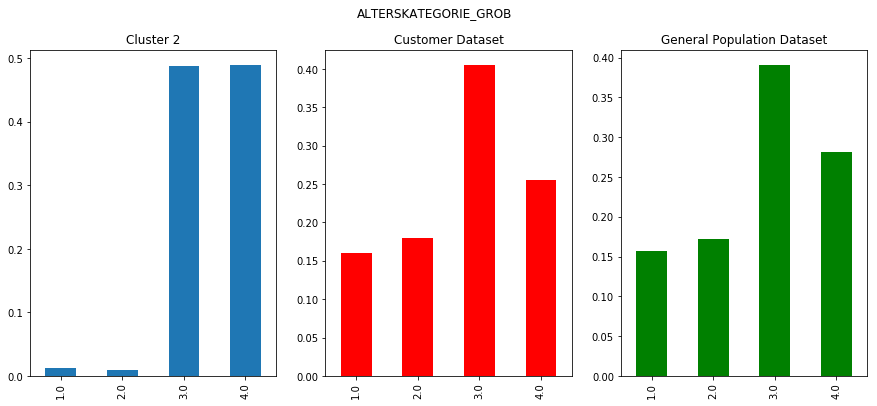

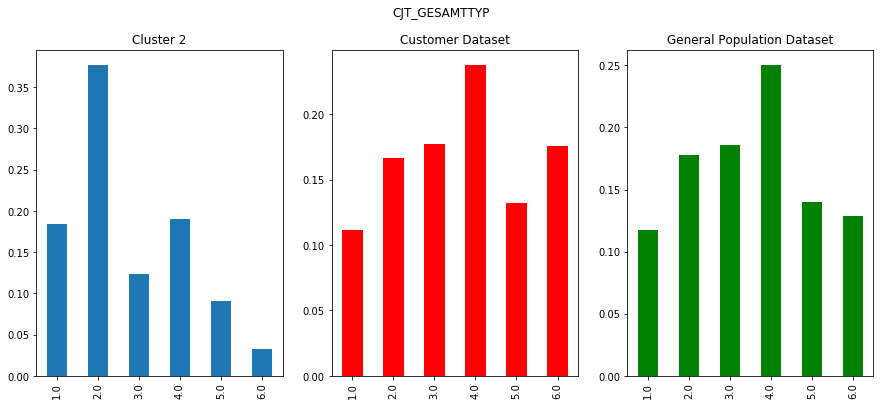

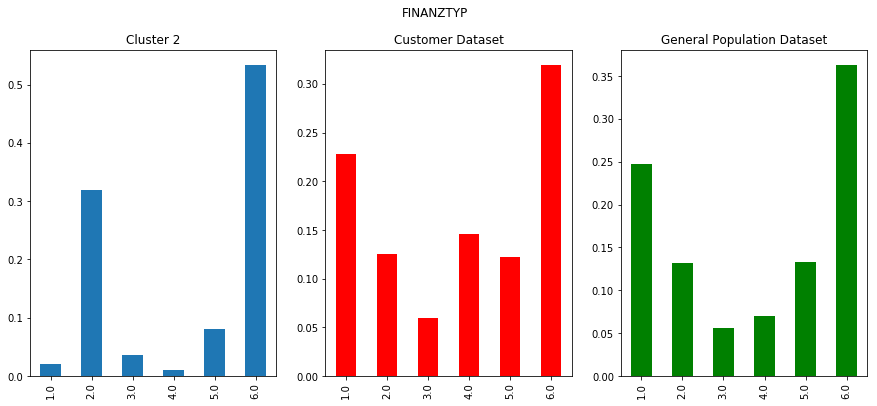

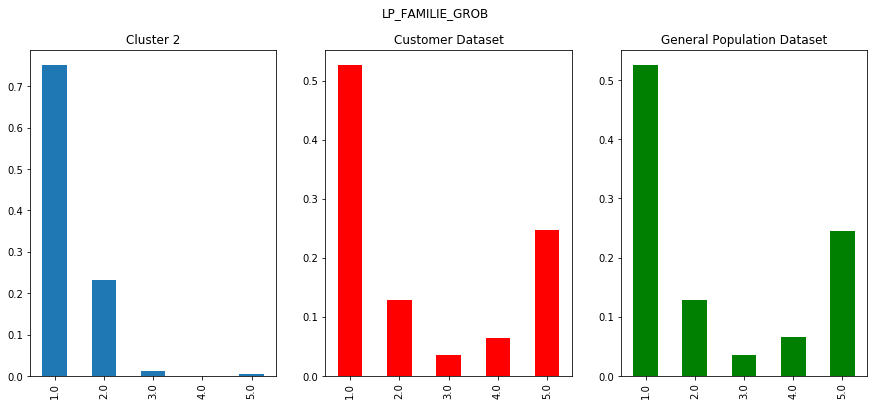

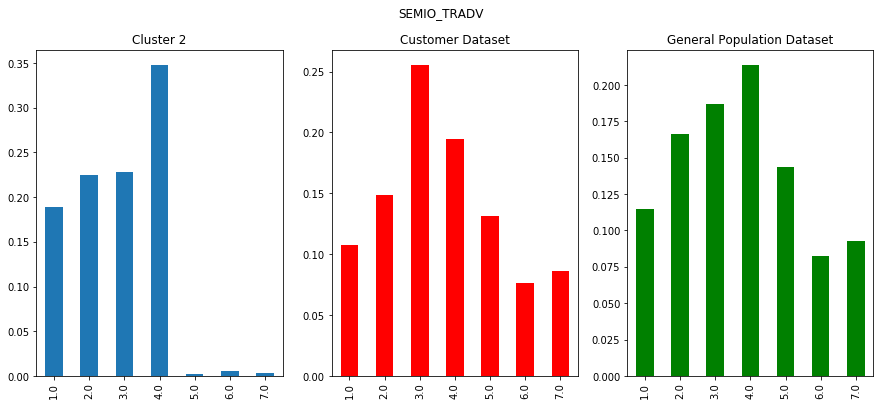

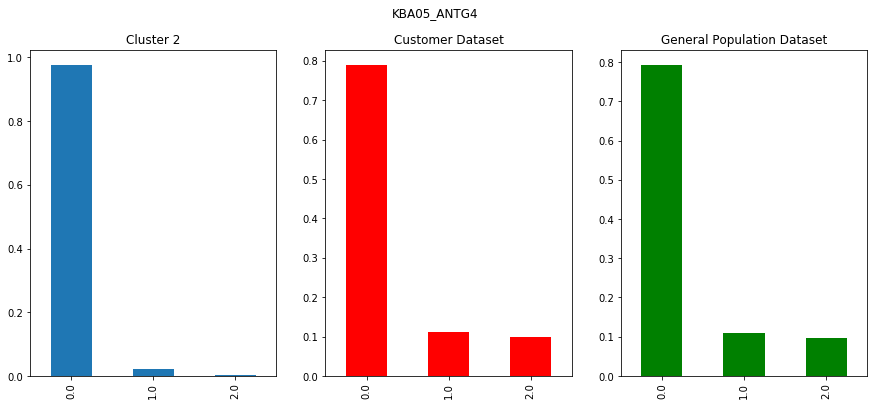

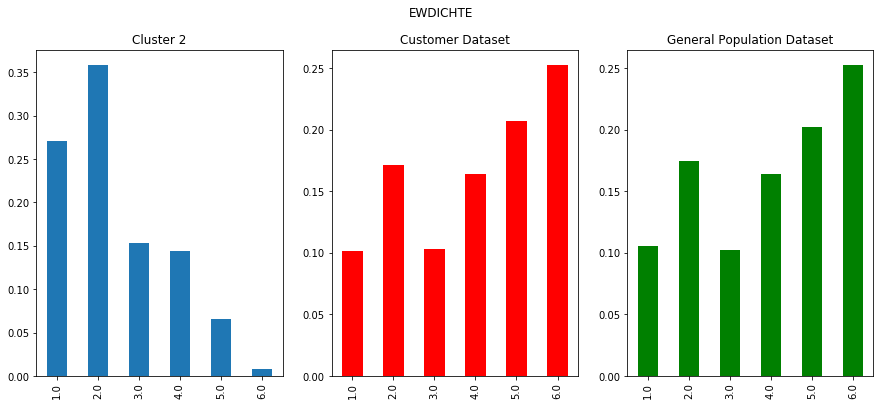

In [111]:
# Underrepresented 

# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

cl_ind = pd.DataFrame(customer_kmeans).idxmin(axis=1)[pd.DataFrame(customer_kmeans).idxmin(axis=1) == 2].index
data = customers_cleaned.iloc[cl_ind,:]
list_cols = ['ALTERSKATEGORIE_GROB','CJT_GESAMTTYP','FINANZTYP','LP_FAMILIE_GROB','SEMIO_TRADV','KBA05_ANTG4','EWDICHTE']


# plot selected features
for i in list_cols:
    fig,axes = plt.subplots(ncols = 3, figsize = (15,6)) 
    data[i].value_counts(normalize = True).sort_index().plot(kind = 'bar', ax = axes[0])
    customers_cleaned[i].value_counts(normalize = True).sort_index().plot(kind = 'bar', ax = axes[1], color = 'red')
    df[i].value_counts(normalize = True).sort_index().plot(kind = 'bar', ax = axes[2], color = 'green')
    axes[0].set_title('Cluster 2')
    axes[1].set_title('Customer Dataset')
    axes[2].set_title('General Population Dataset')
    fig.suptitle(i)
    plt.show()


### Discussion 3.3: Compare Customer Data to Demographics Data

In this section I've clustered a customer data using a model from population data. An analysis of the distribution of cluster portions between two datasets showed that there is one cluster which is likely to be a "key" customer cluster for a mail company (cluster 3). Cluster no 0 showed relatively the same portion, and other clusters were rather underpresented in the customer data. 

This is my interpretation of cluster 3 customers: female, < 60 y.o, advertising-enthusiast, who do not really like to save money or invest it and have high income.

Cluster 2 is underrepresented in customer dataset: traditionally minded male/female >45 y.o without children, advertising-traditionalist, who either saves money (or is not financially active) and lives in either rural areas or in suburbs with low house density.